0  Intro

🌡️ Extreme Temperatures 
Paris → 75
Lyon → 69
Bordeaux → 33
Marseille → 13

We deliberately use daily data rather than hourly data because daily extremes are the standard basis 
for climate and public-health heat indicators, while hourly data would substantially increase 
complexity without improving robustness or interpretability for this project. Daily temperature profiles 
could be used once heatwaves are IDed.  


1  Import libraries

In [29]:
#math libraries
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns


#other
import os
from pathlib import Path

from pathlib import Path

REPO_ROOT = Path.cwd()
if REPO_ROOT.name == "notebooks":
    REPO_ROOT = REPO_ROOT.parent


2 Functions

In [30]:
# define path for raw data
def load_city_data(path):
    """
    Load a Meteo-France CSV file and parse the date column.
    """
    df = pd.read_csv(path, sep=";")
    df.columns = df.columns.astype(str).str.strip()
    df["date"] = pd.to_datetime(df["AAAAMMJJ"], format="%Y%m%d", errors="coerce")
    df = df.dropna(subset=["date"])
    return df


# Select the top 5 meteo stations per city
def select_top_stations(df, min_tx_days=8000, min_end_year=2015, n_stations=5):
    """
    Select the best weather stations based on:
    - number of available TX (daily max temperature) values
    - recent data availability
    """
    summary = (
        df.groupby(["NUM_POSTE", "NOM_USUEL"])
          .agg(
              n_TX=("TX", "count"),
              start_date=("date", "min"),
              end_date=("date", "max")
          )
          .reset_index()
    )

    selected = (
        summary[
            (summary["n_TX"] >= min_tx_days) &
            (summary["end_date"].dt.year >= min_end_year)
        ]
        .sort_values("n_TX", ascending=False)
        .head(n_stations)
    )

    return selected


# Filter results by city/stations
def filter_city_by_stations(df, stations_df):
    """
    Keep only observations from the selected stations.
    """
    station_ids = stations_df["NUM_POSTE"].tolist()
    return df[df["NUM_POSTE"].isin(station_ids)].copy()


3 Load the data

| Variable | Description |
|--------|------------|
| NUM_POSTE | Station ID |
| NOM_USUEL | Station name |
| LAT | Latitude |
| LON | Longitude |
| ALTI | Altitude (m) |
| AAAAMMJJ | Date (YYYYMMDD) |
| date | Parsed date |
| RR | Daily precipitation (mm) |
| QRR | Quality flag (RR) |
| TN | Daily minimum temperature (°C) |
| QTN | Quality flag (TN) |
| HTN | Time of TN |
| TX | Daily maximum temperature (°C) |
| QTX | Quality flag (TX) |
| HTX | Time of TX |
| TM | Mean daily temperature (°C) |
| QTM | Quality flag (TM) |
| TNTXM | (TN + TX) / 2 |
| TAMPLI | Daily thermal amplitude (TX − TN) |
| TNSOL | Min ground temperature (10 cm) |
| TN50 | Min temperature at 50 cm |
| DG | Frost duration (minutes) |
| FFM | Mean daily wind speed (10 m) |
| FF2M | Mean wind speed (2 m) |
| FXY | Max hourly wind (10 m) |
| DXY | Direction of max wind |
| HXY | Time of max wind |
| FXI | Max instantaneous wind (10 m) |
| DXI | Direction of FXI |
| HXI | Time of FXI |
| FXI2 | Max instantaneous wind (2 m) |
| FXI3S | Max 3-second wind gust |
| DRR | Duration of precipitation (min) |
| Q* | Quality flag for variable `*` |


In [31]:
# =========================
# Base path to data folder
# =========================
DATA_DIR = "/Users/leahgoldfarb/Downloads/France meteo DS"

# =========================
# File paths
# =========================
PATH_75 = f"{DATA_DIR}/Paris_Q_75_previous-1950-2023_RR-T-Vent.csv"
PATH_13 = f"{DATA_DIR}/Marseille_Q_13_previous-1950-2023_RR-T-Vent.csv"
PATH_33 = f"{DATA_DIR}/Bordeaux_Q_33_previous-1950-2023_RR-T-Vent.csv"
PATH_69 = f"{DATA_DIR}/Lyon_Q_69_previous-1950-2023_RR-T-Vent.csv"

# =========================
# Load data
# =========================
df_75 = load_city_data(PATH_75)
df_13 = load_city_data(PATH_13)
df_33 = load_city_data(PATH_33)
df_69 = load_city_data(PATH_69)


# =========================
# Preview data
# =========================
print('Paris')
display(df_75.head())
display(df_75.columns)
print('Marseille')
display(df_13.head())
display(df_13.columns)
print('Bordeaux')
display(df_33.head())
display(df_33.columns)
print('Lyon')
display(df_69.head())
display(df_69.columns)

Paris


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR,date
0,75101001,INNOCENTS,48.860667,2.348333,37,19500101,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-01-01
1,75101001,INNOCENTS,48.860667,2.348333,37,19500102,1.8,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-01-02
2,75101001,INNOCENTS,48.860667,2.348333,37,19500103,2.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-01-03
3,75101001,INNOCENTS,48.860667,2.348333,37,19500104,0.2,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-01-04
4,75101001,INNOCENTS,48.860667,2.348333,37,19500105,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-01-05


Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'QRR',
       'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM',
       'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50',
       'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY',
       'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI',
       'QHXI', 'FXI2', 'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S',
       'QFXI3S', 'DXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date'],
      dtype='object')

Marseille


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR,date
0,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620701,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962-07-01
1,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620702,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962-07-02
2,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620703,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962-07-03
3,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620704,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962-07-04
4,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620705,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962-07-05


Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'QRR',
       'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM',
       'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50',
       'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY',
       'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI',
       'QHXI', 'FXI2', 'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S',
       'QFXI3S', 'DXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date'],
      dtype='object')

Bordeaux


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR,date
0,33004001,AMBES,45.041667,-0.608333,5,19571215,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957-12-15
1,33004001,AMBES,45.041667,-0.608333,5,19571216,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957-12-16
2,33004001,AMBES,45.041667,-0.608333,5,19571217,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957-12-17
3,33004001,AMBES,45.041667,-0.608333,5,19571218,21.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957-12-18
4,33004001,AMBES,45.041667,-0.608333,5,19571219,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957-12-19


Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'QRR',
       'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM',
       'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50',
       'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY',
       'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI',
       'QHXI', 'FXI2', 'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S',
       'QFXI3S', 'DXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date'],
      dtype='object')

Lyon


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR,date
0,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630301,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1963-03-01
1,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630302,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1963-03-02
2,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630303,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1963-03-03
3,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630304,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1963-03-04
4,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630305,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1963-03-05


Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'QRR',
       'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM',
       'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50',
       'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY',
       'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI',
       'QHXI', 'FXI2', 'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S',
       'QFXI3S', 'DXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date'],
      dtype='object')

4 Select the 5 stations to keep per city  (same logic for selection) 

In [32]:
# ===============================
# 4  Select top stations per city 
# ===============================

# ------------------------------------------------
# 4.1 Select top 5 stations per city
# ------------------------------------------------

stations_75 = select_top_stations(df_75)  # Paris
stations_13 = select_top_stations(df_13)  # Marseille
stations_33 = select_top_stations(df_33)  # Bordeaux
stations_69 = select_top_stations(df_69)  # Lyon

# ------------------------------------------------
# 4.2 Write temperature-only reference datasets
# ------------------------------------------------
# Uses station metadata returned by select_top_stations (DataFrame)
# Extracts NUM_POSTE explicitly and preserves daily TX continuity
# ------------------------------------------------

from pathlib import Path

TEMP_STATION_DIR = Path("data/temp_station")
TEMP_STATION_DIR.mkdir(parents=True, exist_ok=True)

STATION_COL = "NUM_POSTE"   # confirmed from stations_75
TX_COL = "TX"

def write_temp_station(df_city, stations_df, filename):
    # extract station IDs correctly
    station_ids = stations_df[STATION_COL].astype(str).tolist()

    df_city = df_city.copy()
    df_city[STATION_COL] = df_city[STATION_COL].astype(str)

    df_out = (
        df_city[df_city[STATION_COL].isin(station_ids)]
        .loc[:, ["date", TX_COL, STATION_COL]]
        .sort_values("date")
        .reset_index(drop=True)
    )

    df_out.to_csv(TEMP_STATION_DIR / filename, index=False)
    print(f"Wrote {filename} ({len(df_out)} rows)")

# Write temperature-only reference datasets
write_temp_station(df_75, stations_75, "paris_TX_station.csv")
write_temp_station(df_13, stations_13, "marseille_TX_station.csv")
write_temp_station(df_33, stations_33, "bordeaux_TX_station.csv")
write_temp_station(df_69, stations_69, "lyon_TX_station.csv")

Wrote paris_TX_station.csv (103184 rows)
Wrote marseille_TX_station.csv (133133 rows)
Wrote bordeaux_TX_station.csv (135140 rows)
Wrote lyon_TX_station.csv (134782 rows)


5  Apply station selection 

In [33]:
# ===============================
# 5. Write reference TX-only datasets (Simon)
# ===============================


# --- Paths (AUTHORITATIVE DATA LOCATION) ---
DATA_DIR = Path("data")
TEMP_DATA_DIR = DATA_DIR / "temp_data"
TEMP_STATION_DIR = DATA_DIR / "temp_station"

TEMP_DATA_DIR.mkdir(parents=True, exist_ok=True)

# --- Build city-level daily TX from station files (Simon-compatible) ---
def build_city_tx(filename):
    df = pd.read_csv(TEMP_STATION_DIR / filename, parse_dates=["date"])
    return (
        df.groupby("date", as_index=False)["TX"]
          .max()
    )

df_paris_tx = build_city_tx("paris_TX_station.csv")
df_marseille_tx = build_city_tx("marseille_TX_station.csv")
df_bordeaux_tx = build_city_tx("bordeaux_TX_station.csv")
df_lyon_tx = build_city_tx("lyon_TX_station.csv")

# --- Write FINAL daily TX datasets (overwrite if needed) ---
df_paris_tx.to_csv(TEMP_DATA_DIR / "Paris_daily_TX_raw.csv", index=False)
df_marseille_tx.to_csv(TEMP_DATA_DIR / "Marseille_daily_TX_raw.csv", index=False)
df_bordeaux_tx.to_csv(TEMP_DATA_DIR / "Bordeaux_daily_TX_raw.csv", index=False)
df_lyon_tx.to_csv(TEMP_DATA_DIR / "Lyon_daily_TX_raw.csv", index=False)

print("✓ Section 5 complete: city-level daily TX written to data/temp_data/")

✓ Section 5 complete: city-level daily TX written to data/temp_data/


6 Select variables and rename (work only from *_top dataframes)

click into this section to see the structure


data/
├── temp_data/                     # TX-only, station-level (Simon / climate analysis)
│   ├── Paris_daily_TX_raw.csv
│   ├── Marseille_daily_TX_raw.csv
│   ├── Bordeaux_daily_TX_raw.csv
│   └── Lyon_daily_TX_raw.csv
│
└── temp_wind_data/                # ML-ready, city-level (Leah / modeling)
    ├── temp_wind_paris.csv
    ├── temp_wind_marseille.csv
    ├── temp_wind_bordeaux.csv
    ├── temp_wind_lyon.csv
    └── temp_wind_four_cities.zip



 7. Write ML-ready temp + wind datasets (single source of truth)

In [40]:
# ===============================
# 7. Write ML-ready temp + wind datasets (single source of truth)
# ===============================

# --------------------------------
# Paths
# --------------------------------
TEMP_WIND_DIR = REPO_ROOT / "data" / "temp_wind_data"

# --------------------------------
# Final ML schema (already standardised)
# --------------------------------
FINAL_COL_ORDER = [
    "date",
    "temp_mean_c",
    "temp_max_c",
    "wind_mean_10m_ms",
    "wind_mean_2m_ms",
    "wind_max_hourly_ms",
    "wind_max_inst_ms",
    "wind_gust_3s_ms",
    "wind_dir_max_deg",
    "wind_dir_inst_deg",
]

# --------------------------------
# Helper: load, validate, rewrite in-place
# --------------------------------
def build_and_write_ml_climate(filename, city):
    path = TEMP_WIND_DIR / filename
    df = pd.read_csv(path, parse_dates=["date"])

    missing = set(FINAL_COL_ORDER) - set(df.columns)
    if missing:
        raise ValueError(f"{filename} missing columns: {missing}")

    df = (
        df[FINAL_COL_ORDER]
        .assign(city=city)
        .sort_values("date")
        .reset_index(drop=True)
    )

    df.to_csv(path, index=False)

# --------------------------------
# Overwrite per-city datasets 
# --------------------------------
city_files = {
    "Paris": "temp_wind_paris.csv",
    "Marseille": "temp_wind_marseille.csv",
    "Bordeaux": "temp_wind_bordeaux.csv",
    "Lyon": "temp_wind_lyon.csv",
}

for city, fname in city_files.items():
    build_and_write_ml_climate(fname, city)

print("✓ Section 6 complete: ML-ready temp+wind datasets written as temp_wind_<city>.csv")

✓ Section 6 complete: ML-ready temp+wind datasets written as temp_wind_<city>.csv


8.1 Analyzsis of wind data

In [43]:
# ===============================
# 8. Wind variable availability per city (DISK-BASED)
# ===============================

# --------------------------------
# Paths
# --------------------------------
TEMP_WIND_DIR = REPO_ROOT / "data" / "temp_wind_data"

# --------------------------------
# Wind variables to inspect
# --------------------------------
wind_vars = [
    "wind_mean_10m_ms",
    "wind_mean_2m_ms",
    "wind_max_hourly_ms",
    "wind_max_inst_ms",
    "wind_gust_3s_ms",
    "wind_dir_max_deg",
    "wind_dir_inst_deg"
]

city_files = {
    "Paris": "temp_wind_paris.csv",
    "Marseille": "temp_wind_marseille.csv",
    "Bordeaux": "temp_wind_bordeaux.csv",
    "Lyon": "temp_wind_lyon.csv",
}

rows = []

for city, fname in city_files.items():
    df = pd.read_csv(TEMP_WIND_DIR / fname, parse_dates=["date"])

    for var in wind_vars:
        rows.append({
            "city": city,
            "variable": var,
            "n_non_null": df[var].notna().sum(),
            "coverage_%": round(df[var].notna().mean() * 100, 1),
        })

wind_availability = pd.DataFrame(rows)

# --------------------------------
# ML-ready variables (example threshold)
# --------------------------------
ml_ready_wind = wind_availability[wind_availability["coverage_%"] >= 80]

# --------------------------------
# Wide view for inspection
# --------------------------------
wind_availability_wide = wind_availability.pivot(
    index="variable",
    columns="city",
    values="coverage_%"
)

wind_availability, ml_ready_wind, wind_availability_wide

(         city            variable  n_non_null  coverage_%
 0       Paris    wind_mean_10m_ms       32271        31.3
 1       Paris     wind_mean_2m_ms           0         0.0
 2       Paris  wind_max_hourly_ms       22693        22.0
 3       Paris    wind_max_inst_ms       34907        33.8
 4       Paris     wind_gust_3s_ms       23597        22.9
 5       Paris    wind_dir_max_deg       22488        21.8
 6       Paris   wind_dir_inst_deg       30302        29.4
 7   Marseille    wind_mean_10m_ms      111373        83.7
 8   Marseille     wind_mean_2m_ms           0         0.0
 9   Marseille  wind_max_hourly_ms       78656        59.1
 10  Marseille    wind_max_inst_ms      116510        87.5
 11  Marseille     wind_gust_3s_ms       70959        53.3
 12  Marseille    wind_dir_max_deg       78608        59.0
 13  Marseille   wind_dir_inst_deg      107559        80.8
 14   Bordeaux    wind_mean_10m_ms       80298        59.4
 15   Bordeaux     wind_mean_2m_ms        9551         7

8.2 Intrepretation of wind data: which  feature has the best coverage?

-------------------
wind_max_inst_ms
--------------------

wind_max_inst_ms = Maximum instantaneous wind speed (m/s): The highest wind speed measured at any instant during a given period (1 sec intervals)

From above, Marseille has the best coverage of wind_max_inst_ms. 

In [44]:
# ===============================
# Select ONE wind variable for all cities
# ===============================

# minimum coverage across cities per variable
score_table = (
    wind_availability
    .groupby("variable")["coverage_%"]
    .min()
    .reset_index()
    .rename(columns={"coverage_%": "min_coverage_%"})
    .sort_values("min_coverage_%", ascending=False)
)

score_table

,variable,min_coverage_%
4,wind_max_inst_ms,20.0
5,wind_mean_10m_ms,20.0
0,wind_dir_inst_deg,16.8
1,wind_dir_max_deg,13.8
3,wind_max_hourly_ms,13.8
2,wind_gust_3s_ms,11.6
6,wind_mean_2m_ms,0.0


9 Examine the stations selected

In [45]:
print("Paris stations:")
print(stations_75[["NUM_POSTE", "NOM_USUEL", "n_TX"]])
print('\n')
print("Lyon stations:")
print(stations_69[["NUM_POSTE", "NOM_USUEL", "n_TX"]])
print('\n')
print("Bordeaux stations:")
print(stations_33[["NUM_POSTE", "NOM_USUEL", "n_TX"]])
print('\n')
print("Marseille stations:")
print(stations_13[["NUM_POSTE", "NOM_USUEL", "n_TX"]])


Paris stations:
    NUM_POSTE         NOM_USUEL   n_TX
16   75114001  PARIS-MONTSOURIS  27028
3    75106001        LUXEMBOURG  16648
23   75116002         BAGATELLE   9608
15   75113002       SALPETRIERE   9556
6    75107005       TOUR EIFFEL   9220


Lyon stations:
    NUM_POSTE       NOM_USUEL   n_TX
10   69029001       LYON-BRON  27028
75   69204002  ST-GENIS-LAVAL  26962
56   69141001         MORNANT  26655
53   69135001         MONSOLS  26508
99   69264001    VILLEFRANCHE  24461


Bordeaux stations:
     NUM_POSTE                NOM_USUEL   n_TX
75    33236002               CAP-FERRET  27028
143   33529001                   CAZAUX  27028
81    33281001        BORDEAUX-MERIGNAC  27028
131   33504001                SAUTERNES  27027
153   33550001  VILLENAVE D'ORNON-INRAE  26997


Marseille stations:
     NUM_POSTE          NOM_USUEL   n_TX
44    13047001             ISTRES  27028
51    13054001          MARIGNANE  27028
108   13103001  SALON DE PROVENCE  27028
2     13001009    AIX 

10  👀 Visualize Tx (Max temp: weather) and averaged tempartures (climate change)

In [ ]:


# =========================
# Functions 
# =========================

def prepare_df(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["AAAAMMJJ"], format="%Y%m%d")
    return df

def station_quality(df):
    return (
        df.groupby("NOM_USUEL")["TX"]
        .apply(lambda x: x.isna().mean())
        .sort_values()
    )

def plot_daily_tx(df, station):
    d = df[df["NOM_USUEL"] == station]
    plt.figure()
    plt.plot(d["date"], d["TX"])
    plt.title(f"Daily TX – {station}")
    plt.xlabel("Year")
    plt.ylabel("TX (°C)")
    plt.show()

# This operation groups daily TX values by calendar year and 
# computes the arithmetic mean for each year, without applying any running or rolling average.
def plot_annual_tx(df, station):
    d = df[df["NOM_USUEL"] == station].dropna(subset=["TX"])
    d["year"] = d["date"].dt.year
    annual = d.groupby("year")["TX"].mean()

    plt.figure()
    plt.plot(annual.index, annual.values)
    plt.title(f"Annual mean TX – {station}")
    plt.xlabel("Year")
    plt.ylabel("TX (°C)")
    plt.show()

def export_city(df, city_name):
    cols = ["date", "NUM_POSTE", "NOM_USUEL", "TX", "TN", "LAT", "LON", "ALTI"]
    df[cols].to_csv(f"{city_name}_daily_TX_raw.csv", index=False)

# =========================
# Apply to all cities
# =========================

cities = {
    "Paris": df_75,
    "Marseille": df_13,
    "Bordeaux": df_33,
    "Lyon": df_69
}

for city, df in cities.items():
    df = prepare_df(df)

    tx_missing = station_quality(df)
    best_station = tx_missing.index[0]

    plot_daily_tx(df, best_station)
    plot_annual_tx(df, best_station)

    export_city(df, city)

Interpretation: Tx just shows weather when plotted. Taking the annual mean shows climate change.

11 Simon's extreme heat visuals and anslysis

PARIS-MONTSOURIS – 27028 days, 0 missing (0.0%)


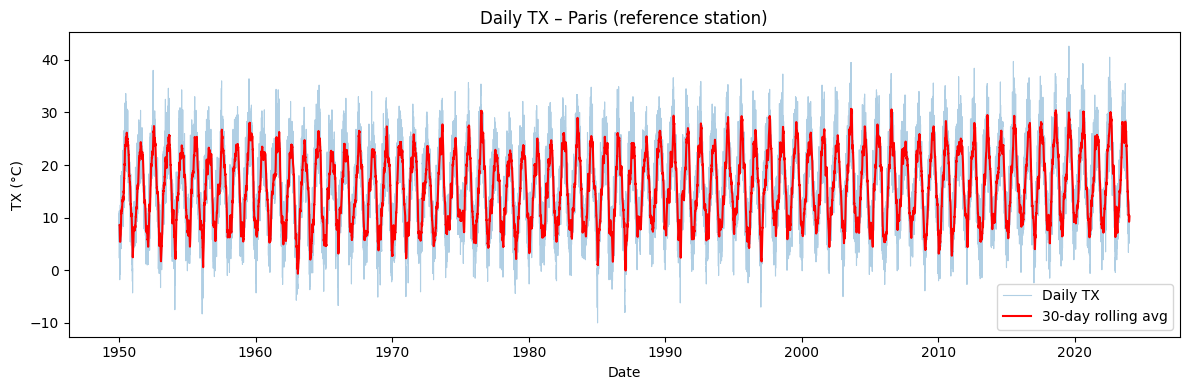

AIX EN PROVENCE – 25021 days, 0 missing (0.0%)


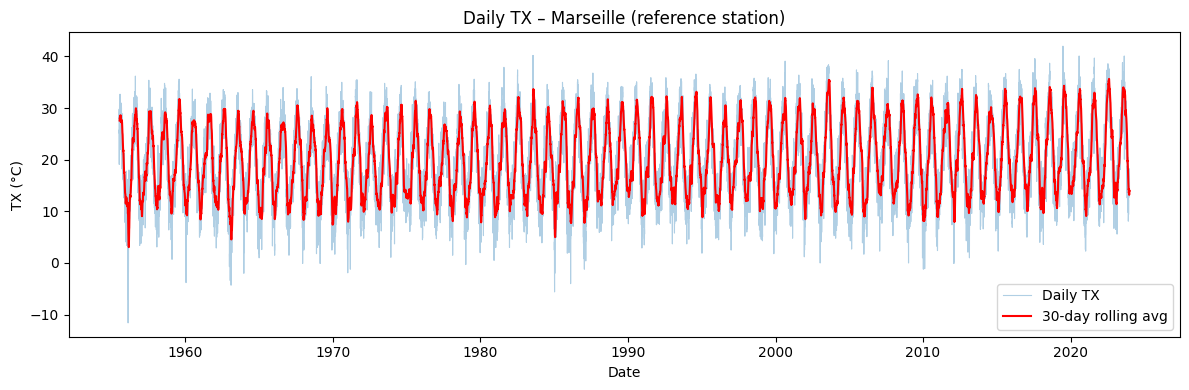

BORDEAUX-MERIGNAC – 27028 days, 0 missing (0.0%)


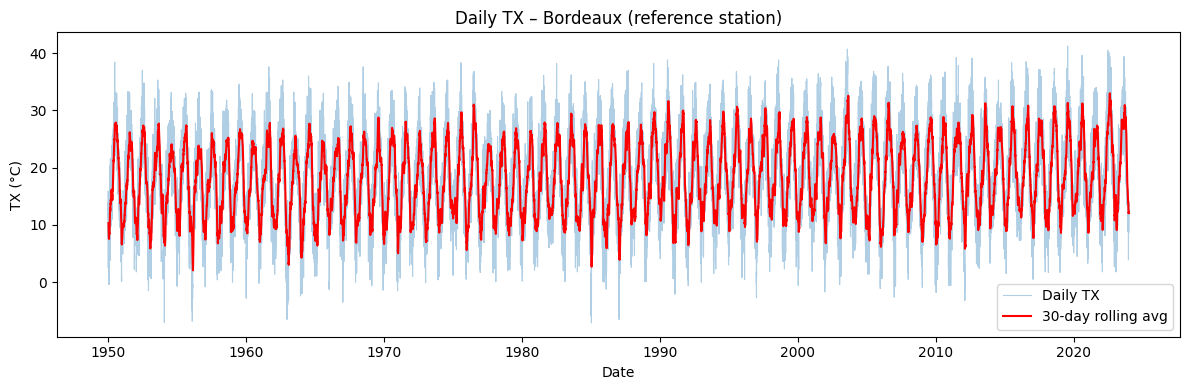

LYON-BRON – 27028 days, 0 missing (0.0%)


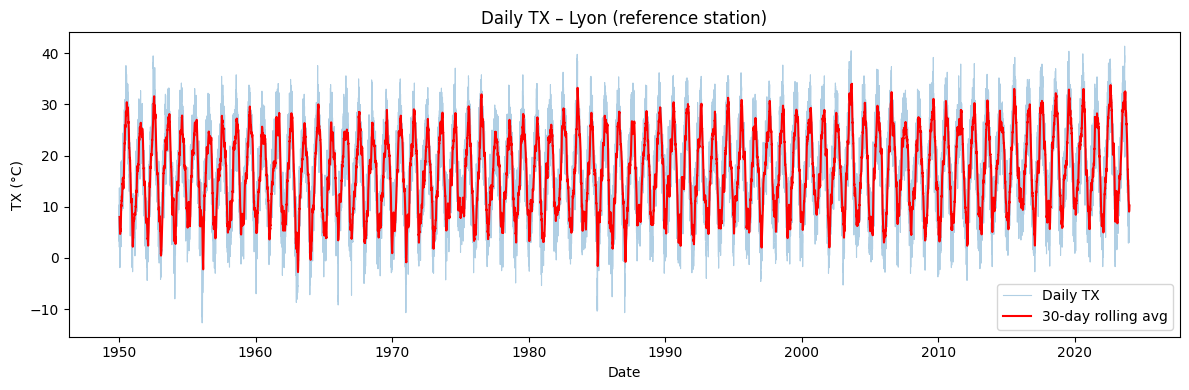

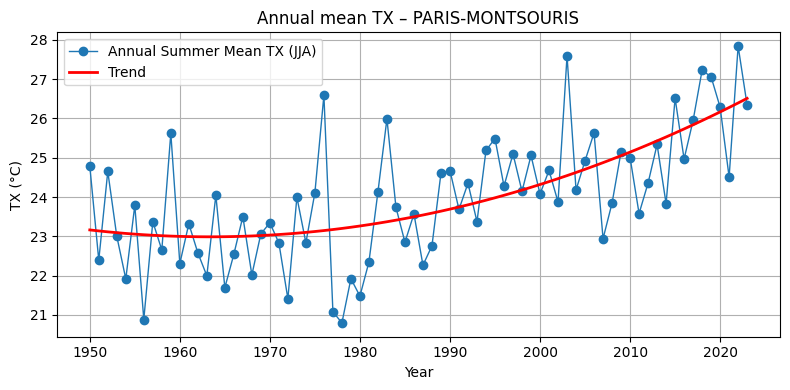

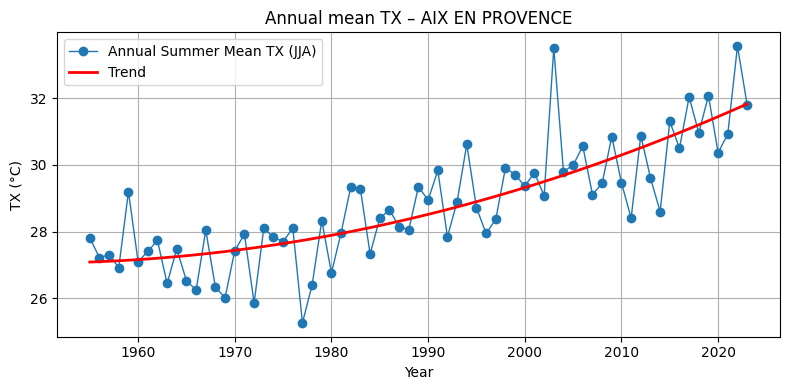

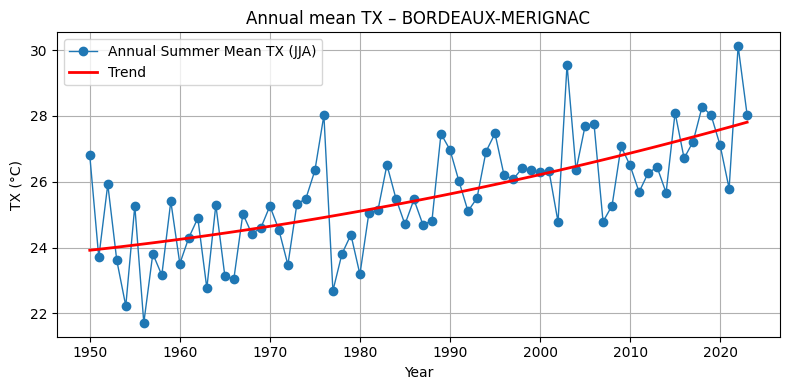

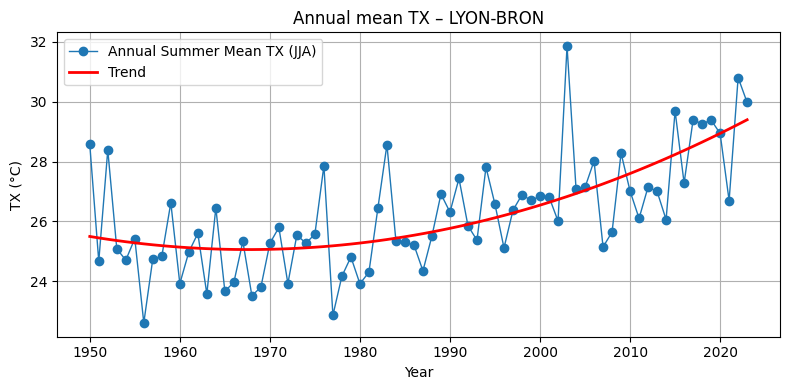

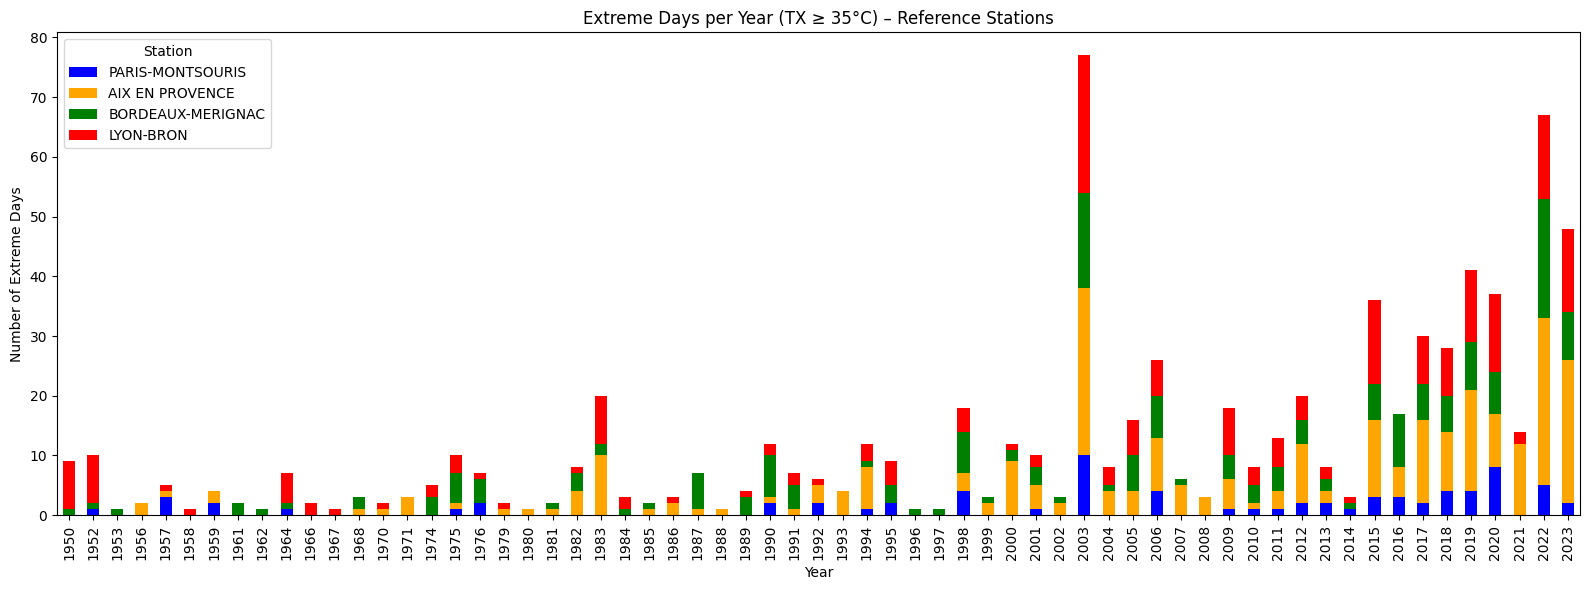

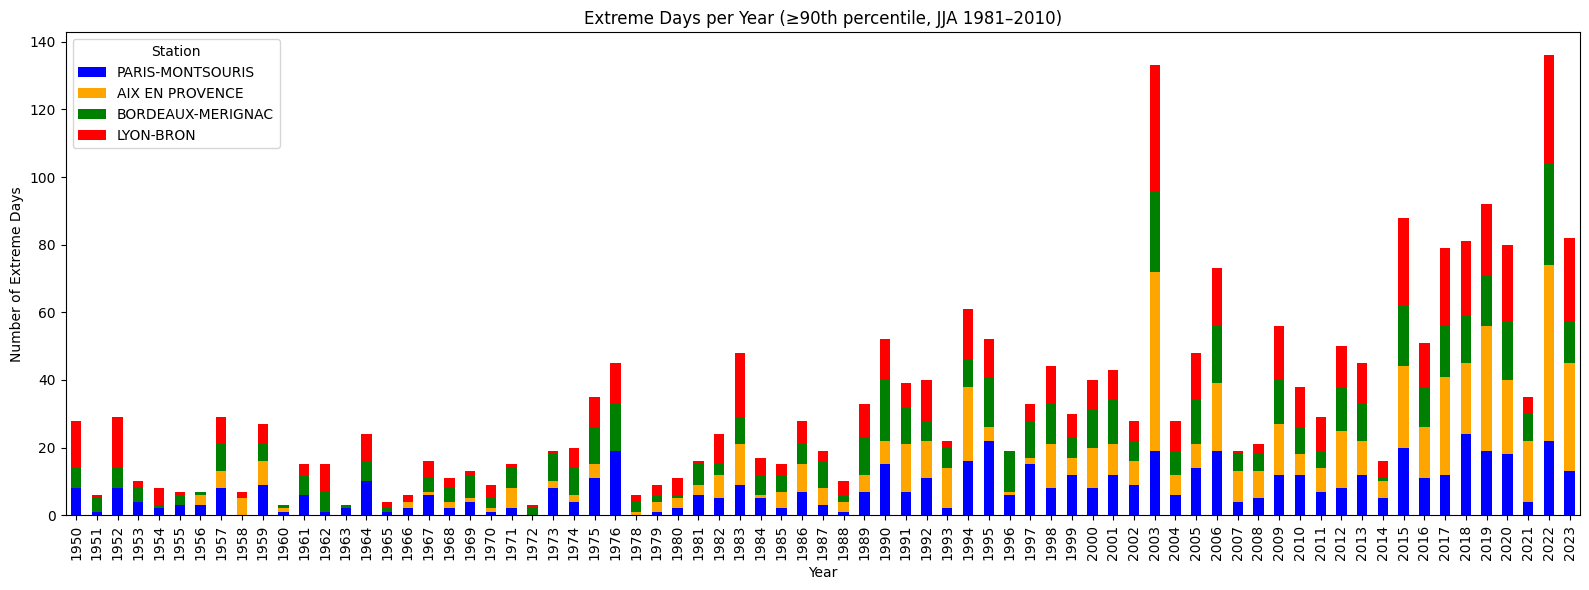

In [46]:
# ============================================================
# 11. Simon’s analysis – TX-only, station-level (FIREWALL)
# ============================================================
#
# This section intentionally RELOADS raw TX data and ignores
# all previous pipeline outputs (temp+wind, ML-ready data, etc.).
#
# Purpose:
# - reproduce Simon’s exploratory figures EXACTLY
# - station-level (single reference station per city)
# - visible gaps reflect real station availability
#
# Rolling means (30-day, 5-year):
# - NOT climatological indicators
# - used only for visual interpretation
# ============================================================

from pathlib import Path

# ------------------------------------------------------------
# 11.0 Load raw station-level TX data (Simon’s source of truth)
# ------------------------------------------------------------

TX_DATA_DIR = REPO_ROOT / "data" / "temp_data"

df_station = pd.concat(
    [
        pd.read_csv(TX_DATA_DIR / "Paris_daily_TX_raw.csv"),
        pd.read_csv(TX_DATA_DIR / "Marseille_daily_TX_raw.csv"),
        pd.read_csv(TX_DATA_DIR / "Bordeaux_daily_TX_raw.csv"),
        pd.read_csv(TX_DATA_DIR / "Lyon_daily_TX_raw.csv"),
    ],
    ignore_index=True
)

df_station["date"] = pd.to_datetime(df_station["date"])

# Keep ONLY what Simon used
df_station = df_station[["date", "TX", "NOM_USUEL"]].copy()

# Time helpers
df_station["year"] = df_station["date"].dt.year
df_station["month"] = df_station["date"].dt.month

# ------------------------------------------------------------
# Reference stations (exactly Simon’s)
# ------------------------------------------------------------

REFERENCE_STATIONS = {
    "Paris": "PARIS-MONTSOURIS",
    "Marseille": "AIX EN PROVENCE",
    "Bordeaux": "BORDEAUX-MERIGNAC",
    "Lyon": "LYON-BRON",
}

# ============================================================
# 11.1 Daily TX + 30-day rolling mean (per reference station)
# ============================================================

for city, station_name in REFERENCE_STATIONS.items():

    df_city = df_station[df_station["NOM_USUEL"] == station_name].copy()
    df_city = df_city.sort_values("date")

    n_days = len(df_city)
    n_missing = df_city["TX"].isna().sum()

    print(
        f"{station_name} – {n_days} days, "
        f"{n_missing} missing ({100 * n_missing / n_days:.1f}%)"
    )

    df_city["TX_30d"] = df_city["TX"].rolling(
        window=30, min_periods=15
    ).mean()

    plt.figure(figsize=(12, 4))

    plt.plot(
        df_city["date"],
        df_city["TX"],
        alpha=0.35,
        linewidth=0.8,
        label="Daily TX"
    )

    plt.plot(
        df_city["date"],
        df_city["TX_30d"],
        color="red",
        linewidth=1.5,
        label="30-day rolling avg"
    )

    plt.title(f"Daily TX – {city} (reference station)")
    plt.xlabel("Date")
    plt.ylabel("TX (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================
# 11.2 Annual summer mean TX (JJA) + smooth trend
# ============================================================

for city, station_name in REFERENCE_STATIONS.items():

    df_city = df_station[
        (df_station["NOM_USUEL"] == station_name) &
        (df_station["month"].isin([6, 7, 8]))
    ].copy()

    annual_mean = (
        df_city
        .groupby("year")["TX"]
        .mean()
        .reset_index()
    )

    # Smooth trend (Simon-style visual trend)
    z = np.polyfit(annual_mean["year"], annual_mean["TX"], 2)
    p = np.poly1d(z)

    plt.figure(figsize=(8, 4))

    plt.plot(
        annual_mean["year"],
        annual_mean["TX"],
        marker="o",
        linewidth=1,
        label="Annual Summer Mean TX (JJA)"
    )

    plt.plot(
        annual_mean["year"],
        p(annual_mean["year"]),
        color="red",
        linewidth=2,
        label="Trend"
    )

    plt.title(f"Annual mean TX – {station_name}")
    plt.xlabel("Year")
    plt.ylabel("TX (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ============================================================
# 11.3 Extreme heat days per year (TX ≥ 35°C) – stacked bars
# ============================================================

df_extreme = df_station[
    (df_station["TX"] >= 35) &
    (df_station["NOM_USUEL"].isin(REFERENCE_STATIONS.values()))
].copy()

extreme_counts = (
    df_extreme
    .groupby(["year", "NOM_USUEL"])
    .size()
    .unstack(fill_value=0)
)

# Enforce consistent station order (prevents KeyErrors)
extreme_counts = extreme_counts[list(REFERENCE_STATIONS.values())]

colors = {
    "PARIS-MONTSOURIS": "blue",
    "AIX EN PROVENCE": "orange",
    "BORDEAUX-MERIGNAC": "green",
    "LYON-BRON": "red",
}

extreme_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 6),
    color=[colors[c] for c in extreme_counts.columns]
)

plt.title("Extreme Days per Year (TX ≥ 35°C) – Reference Stations")
plt.xlabel("Year")
plt.ylabel("Number of Extreme Days")
plt.legend(title="Station")
plt.tight_layout()
plt.show()

# ============================================================
# 11.4 Extreme days per year (≥90th percentile, JJA 1981–2010)
# ============================================================

baseline = df_station[
    (df_station["year"].between(1981, 2010)) &
    (df_station["month"].isin([6, 7, 8]))
]

p90 = (
    baseline
    .groupby("NOM_USUEL")["TX"]
    .quantile(0.9)
)

df_p90 = df_station[
    (df_station["month"].isin([6, 7, 8])) &
    (df_station["NOM_USUEL"].isin(p90.index))
].copy()

df_p90["is_extreme"] = df_p90.apply(
    lambda r: r["TX"] >= p90[r["NOM_USUEL"]],
    axis=1
)

extreme_90 = (
    df_p90[df_p90["is_extreme"]]
    .groupby(["year", "NOM_USUEL"])
    .size()
    .unstack(fill_value=0)
)

extreme_90 = extreme_90[list(REFERENCE_STATIONS.values())]

extreme_90.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 6),
    color=[colors[c] for c in extreme_90.columns]
)

plt.title("Extreme Days per Year (≥90th percentile, JJA 1981–2010)")
plt.xlabel("Year")
plt.ylabel("Number of Extreme Days")
plt.legend(title="Station")
plt.tight_layout()
plt.show()